In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    !pip3 install pickle5 -q
    !apt-get install p7zip-full -q
    !7z x 'drive/MyDrive/Colab Notebooks/Project/FreiHAND_split.7z'
    !7z x 'drive/MyDrive/Colab Notebooks/Project/RHD_published_v2.zip'
    !cp 'drive/MyDrive/Colab Notebooks/Project/Networks.py' .
    !cp 'drive/MyDrive/Colab Notebooks/Project/HandDataset_noCoords.py' .
    !cp 'drive/MyDrive/Colab Notebooks/Project/Rotations.py' .
    PATH = "drive/MyDrive/Colab Notebooks/Project/"
except:
    IN_COLAB = False
    PATH = ""

Mounted at /content/drive
     |████████████████████████████████| 256 kB 15.3 MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 484355643 bytes (462 MiB)

Extracting archive: drive/MyDrive/Colab Notebooks/Project/FreiHAND_split.7z
--
Path = drive/MyDrive/Colab Notebooks/Project/FreiHAND_split.7z
Type = 7z
Physical Size = 484355643
Headers Size = 412810
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 7        0% 7 - FreiHAND_split/evaluation/color/00024420.jpg                         

In [2]:
if IN_COLAB:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)

Tue Dec  7 05:13:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from importlib import reload

from HandDataset_noCoords import *
from Networks import *

manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [4]:
batch_size = 128
img_size = 64
nc, nz = 3, 128 # number of channels in training images
ngf, ndf = 64, 64
num_epochs = 50
lr, beta1 = 0.0002, 0.5 # hyperparam for Adam optimizers

In [ ]:
synth_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    #transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # (replace with actual mean and std)
])

real_transform = transforms.Compose([
    transforms.CenterCrop(112),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    #transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # (replace with actual mean and std)
])



synth_ds = HandDataset(
    img_dir='RHD_published_v2/training/color',
    mask_dir='RHD_published_v2/training/mask',
    anno_path='RHD_published_v2/training/anno_training.pickle',
    black_size=320,
    zfill=5,
    ext='.png',
    transform=synth_transform,
    masked=True,
    centered=True,
    coef = 2.2,
    normalise=True
)

real_ds = HandDataset(
    img_dir='FreiHAND_split/training/rgb',
    mask_dir='FreiHAND_split/training/mask',
    anno_path='FreiHAND_split/FreiHAND_anno_training.pickle', # incomplete (only contains xyz data)
    zfill=8,
    ext='.jpg',
    black_size=224,
    masked=True,
    transform=real_transform,
    normalise=True
)

In [ ]:
synth_loader = DataLoader(synth_ds, batch_size=batch_size, shuffle=True, drop_last=True)
real_loader = DataLoader(real_ds, batch_size=batch_size, shuffle=True, drop_last=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
Enc = Encoder(nz=nz, nf=ngf).to(device)
Enc.apply(weights_init)

Encoder(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (fc): Linear(in_features=16384, out_features=1024, bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (activ): LeakyReLU(negative_slope=0.2)
  (mu): Linear(in_features=1024, out_features=128, bias=True)
  (logVar): Linear(in_features=1024, out_features=128, bias=True)
)

In [ ]:
Dec = Decoder(nz=nz, nf=ndf).to(device)
Dec.apply(weights_init)

Decoder(
  (fc): Linear(in_features=128, out_features=16384, bias=False)
  (conv1): ConvTranspose2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (conv2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (conv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (conv4): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm1d(16384, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (activ): LeakyReLU(negative_slope=0.2)
)

In [ ]:
optimizerEnc = optim.Adam(Enc.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerDec = optim.Adam(Dec.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_synth = next(iter(synth_loader))[0][:64].to(device)
fixed_real = next(iter(real_loader))[0][:64].to(device)

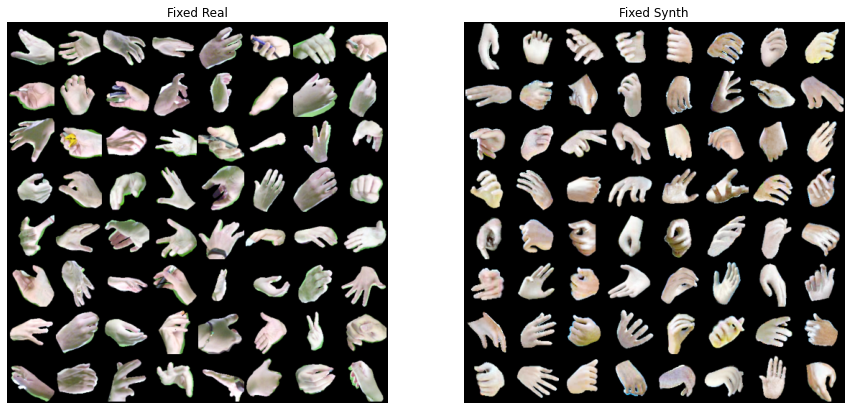

In [ ]:
plt.figure(figsize=(15,30))
ax = plt.subplot(2,2,1)
plt.axis('off')
plt.title('Fixed Real')
plt.imshow(np.transpose(vutils.make_grid(fixed_real[:64],
                                        padding=2, normalize=True).cpu(),(1,2,0)))

ax = plt.subplot(2,2,2)
plt.axis('off')
plt.title('Fixed Synth')
plt.imshow(np.transpose(vutils.make_grid(fixed_synth[:64],
                                        padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
img_list_real, img_list_fake, loss = [],[],[]
iters, epoch, num_epochs = 0,0,30

In [ ]:
print("Starting Training Loop...")

while epoch < num_epochs:
    ##########################################
    # (0) Set up iterations of both loaders  #
    ##########################################
    synth_loader_iterator = iter(synth_loader)
    for i, real_batch in enumerate(real_loader):
        try:
            synth_batch = next(synth_loader_iterator)
        except StopIteration:
            synth_loader_iterator = iter(synth_loader)
            synth_batch = next(synth_loader_iterator)
    
        Enc.zero_grad()
        Dec.zero_grad()
        
        # Real batch
        x = real_batch[0].to(device)
        mu, logVar = Enc(x)
        z = reparameterize(mu, logVar)
        x_hat = Dec(z)
        
        kl_divergence = 0.5 * torch.sum(-1 -logVar + mu.pow(2) + logVar.exp())
        errR = F.mse_loss(x_hat, NormaliseBatch(x), reduction='sum') + kl_divergence
        errR.backward()
        
        ## Fake Batch
        x = synth_batch[0].to(device)
        mu, logVar = Enc(x)
        z = reparameterize(mu, logVar)
        x_hat = Dec(z)
        
        kl_divergence = 0.5 * torch.sum(-1 -logVar + mu.pow(2) + logVar.exp())
        errF = F.mse_loss(x_hat, NormaliseBatch(x), reduction='sum') + kl_divergence
        errF.backward()
        
        err = errF + errR
        loss.append(err.item())
 
        optimizerEnc.step()
        optimizerDec.step()
  
        if i % 50 == 0:
            print('[%d][%d/%d]\tLoss: %.3f'
                  % (epoch, i, len(synth_loader),
                     err.item()))
            
        if iters % 500 == 0:
            with torch.no_grad():
                mu,logVar = Enc(fixed_real)
                z = reparameterize(mu,logVar)
                x = Dec(z).detach().cpu()
                img_list_real.append(vutils.make_grid(x, padding=2, normalize=True))
                
                mu,logVar = Enc(fixed_synth)
                z = reparameterize(mu,logVar)
                x = Dec(z).detach().cpu()
                img_list_fake.append(vutils.make_grid(x, padding=2, normalize=True))

                plt.figure(figsize=(8,8))
                plt.axis('off')
                #plt.title('Fixed noise generated')
                plt.imshow(np.transpose(vutils.make_grid(x[:64],
                                                        padding=2, normalize=True).cpu(),(1,2,0)))
                plt.pause(0.01)
            
        iters += 1
    epoch += 1

Output hidden; open in https://colab.research.google.com to view.

No handles with labels found to put in legend.


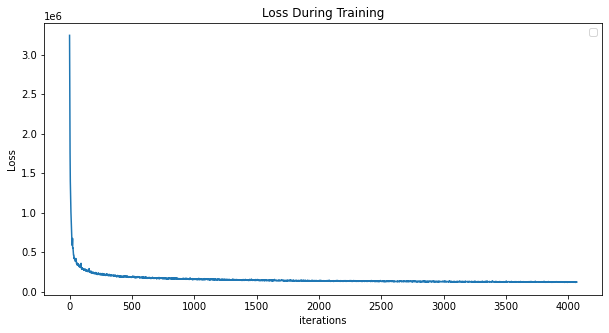

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(loss)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(Enc.state_dict(), PATH+'models/vae/Enc_epoch_{}.pth'.format(epoch))
torch.save(Dec.state_dict(), PATH+'models/vae/Dec_epoch_{}.pth'.format(epoch))